#### **Import Libraries**

In [17]:
import jax 
import jax.numpy as jnp 
from rfp import MLP, Model, ModelParams
from rfp.losses import Supervised_Loss, mse, Cluster_Loss
from rfp.train import Trainer
import optax 
jax.config.update("jax_debug_nans", True)

In [18]:
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
plt.style.use('seaborn-v0_8-dark-palette')

from matplotlib import font_manager 
locations = './../../styles/Newsreader'
font_files = font_manager.findSystemFonts(fontpaths=locations)
print(locations)
print(font_files[0])
for f in font_files: 
    font_manager.fontManager.addfont(f)
plt.rcParams["font.family"] = "Newsreader"

./../../styles/Newsreader
/home/ubuntu/rfp/styles/Newsreader/static/Newsreader_14pt/Newsreader_14pt-LightItalic.ttf


#### **Hyperparameters**

In [121]:
nodes = 32
clusters = 5
inner_epochs = 3 
inner_lr = 0.01
outer_epochs = 1000 
outer_lr = 0.01

#### **Generate Data**

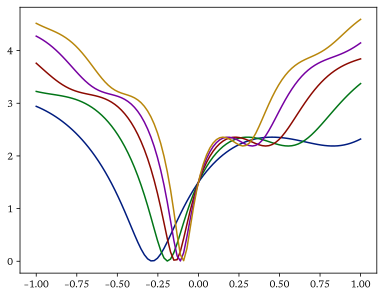

In [122]:
def main_effect(x, p):
    x = 3*x*p # This is so we don't have to normalize the inputs later
    return jnp.log(x**2 + 1.0 + jnp.sin(x*3.0)) + 1.5

xs = jnp.linspace(-1., 1., 100).reshape(-1,1)
Xs = jnp.tile(xs, (clusters, 1, 1))
ps = jnp.linspace(0.5, 1.5, clusters)
Ys = jax.vmap(main_effect, in_axes=(None, 0))(xs, ps)

for y in Ys:
    plt.plot(xs, y)
plt.show()

In [123]:
features = xs.shape[1] 
mlp = MLP([nodes, nodes], jax.nn.relu)
model = Model(mlp, lambda x: x)
supervised_loss = Supervised_Loss(mse, model.embellished_fwd_pass, reg_value=0, aux_status=False)
inner_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=inner_lr, momentum=0.9), inner_epochs)
cluster_loss = Cluster_Loss(inner_yuri, reg_value=1.)
yuri = Trainer(cluster_loss, optax.sgd(learning_rate=outer_lr, momentum=0.9), outer_epochs)

In [124]:
init_key = jax.random.PRNGKey(0)
params = ModelParams.init_fn(init_key, mlp, features)
opt_params, loss_history = yuri.train(params, Xs, Ys, jnp.ones_like(Ys).squeeze())

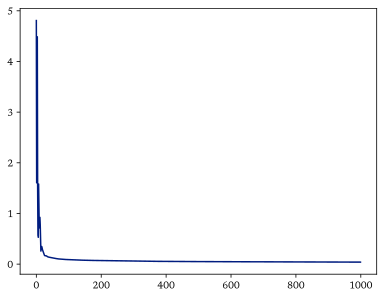

In [125]:
plt.plot(loss_history)
plt.show()

In [126]:
p, l = inner_yuri.train(opt_params, xs, Ys[0], jnp.ones_like(Ys[0]))

In [127]:
inner_params = [] 
inner_losses = [] 
for i in Ys:
    inner_opt_params, l = inner_yuri.train(opt_params, xs, i, jnp.ones_like(i))
    inner_params.append(inner_opt_params)
    inner_losses.append(l)

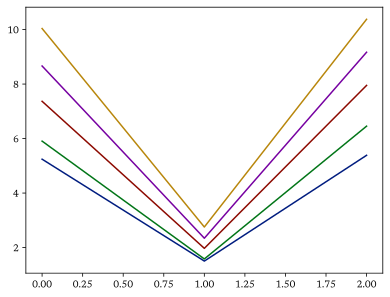

In [128]:
for i in inner_losses:
    plt.plot(i)
plt.show()

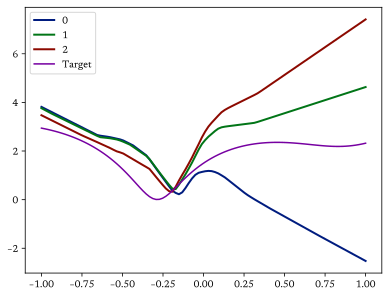

In [137]:
for i in range(inner_epochs):
    inner_yuri = Trainer(supervised_loss, optax.sgd(learning_rate=inner_lr, momentum=0.9), i)
    inner_param, _ = inner_yuri.train(opt_params, xs, Ys[0], jnp.ones_like(Ys[0]))
    
    yhat = model.fwd_pass(inner_param, xs)
    plt.plot(xs, yhat, linewidth=2, label=i)
plt.plot(xs, Ys[0], label='Target')
plt.legend()
plt.show()


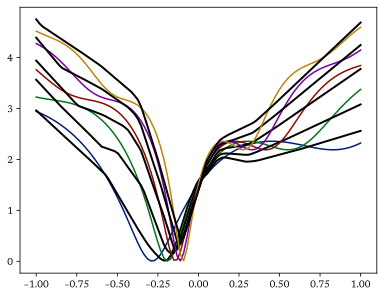

In [129]:
for i in range(clusters):
    plt.plot(xs, Ys[i])
    yhat = model.fwd_pass(inner_params[i], xs)
    plt.plot(xs, yhat, color='black', linewidth=2)
plt.show()

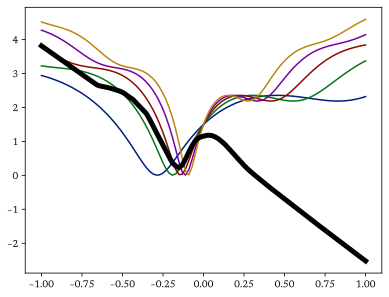

In [130]:
for y in Ys:
    plt.plot(xs, y)
yhat = model.fwd_pass(opt_params, xs)
plt.plot(xs, yhat, color='black', linewidth=5)
plt.show()

